# Scraping Google Finance.ipynb

**Author:** Fred Stelwagon  
**Date:** 4/8/2025  
**Class:** CMP-262 Data Science Programming  
**Project 2:** Web Scraping  
**Submission 2:** Web Scraped Data Analysis & Advanced Visualization

### Purpose
The purpose of this analysis is to introduce the concepts web scraping using BeutifulSoup and advanced visualization using Seaborn. The data selected for this analysis was stock price data from Google Finance.  

### Analysis: Answer 5 Questions:  
1. What are the top performering stocks in My Portfolio this trading session? What are the worst performers?  
2. What is the Total Value, Total Change and Percent Change in My Portfolio in this trading session?  
3. How did My Portfolio perform against Market Indexes this trading session?  
4. How did My Portfolio atocks perform against Most Active, Top Gainers and Top Losers?  
5. Do any stocks in My Portfolio appear in Most Active, Top Gainers or Top Losers?   

### Approach:  
The following sections reflect the approach to gather the data and perform the analysis:  
* Import Libraries Used in Code  
* Set Path for Google Chrome Executable ... used by Selenium to scrape elements unscrapable using BeutifulSoup.  
* Define Function: traffic_cop ... used to space requests to the website to avoid being blocked.  
* Define Function: request_page ... used to request contents of a given webpage.  
* Request Pages  
* Print Prettified Soup Text (for scraping analysis)    
* Scrape Indexes ... Indexes being one of the Google Finance data table pages for Market Indexes.  
* Define Function: scrape_leaders ... used to scrape Google Finance data table pages for leaders: Most Active, Top Gainers & Top Losers.  
* Scrape 'Most Active' Leader's Board  
* Scrape 'Gainers' Leader's Board  
* Scrape 'Losers' Leader's Board   
* Delete Scraped Soup Objects ... to free resources.  
* Import My Portfolio CSV ... contains information on individual stocks making up 'My Portfolio'.  
* Define Function: scrape_stock ... used to scrape information from an individual stock page in Google Finance.  
* Define Function: scrape_portfolio ... used to scrape information from all stocks in 'My Portfolio'.  
* Update Portfolio ... updates the My Portfolio with individual stock pricing information scraped from Google Finance.  
* QUESTION 1: What are the Top Performers in My Portfolio? What are the Worst Performers?  
* QUESTION 2: What is the Total Value, Total Change and Percent Change in My Portfolio in this Trading Session?  
* QUESTION 3: How does My Portfolio Perform against Market Indexes?  
* QUESTION 4: How does My Portfolio Stocks Perform against Most Active, Top Gainers and Top Losers?  
* QUESTION 5: Do any stocks in My Portfolio appear in Most Active, Top Gainers or Top Losers?  

### Import Libraries Used in Code  
The following are libraries used in the code to follow:

In [1]:
# Pandas Library.
import pandas as pd

# Date/Time Libraries.
import time                           # Time library, used by 'traffic_cop' function to space scrape requests and avoid being blocked.
from datetime import datetime         # Datetime library, used by 'traffic_cop' function to space scrape requests and avoid being blocked.

# Miscellaneous Libraries.
import random as rnd                  # Random library, used by 'traffic_cop' function to randomly space scrape requests to make them look non-automated.
import gc                             # Garbage Collection library, used to clear deleted resources. 
import warnings                       # Used to sppress FutureWarning.

# Web Scraping with Beautiful Soup Libraries.
import requests                       # Requests library, used to scrape websites.
from bs4 import BeautifulSoup as bs   # BeautifulSoup library, used to traverse, parse and extract information from scraped websites.
from requests.exceptions import HTTPError, ConnectionError, RequestException # HTML, connection and request error libraries used in error handling when making webpage requests.

# Selenium Libraries.
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Seaborn and Matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

### Set Path for Google Chrome Executable  
This code uses Selenium to actively scrape elements that are not scrapable using BeautifulSoup. To do this, Google Chrome MUST be installed on the computer executing this code and the path to the Chrome executable needs to be entered below. 

In [2]:
# Update this path to where Chrome is installed on your system.
#chrome_path = '/Applications/Google Chrome.app/Contents/MacOS/Google Chrome'  # For MacOS
chrome_path = 'C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe'    # Windows Path

### Define Function: traffic_cop  
##### Purpose:    
Function to moderate scrape requests to avoid being blocked. The function will delay the code randomly for 3 to 7 seconds before proceeding. The randomness and time range is intended to mimic a human user.   
  
##### Arguments:  
* last_scrape_time: Timestamp (optional) of the last scrape. Optional. If not provided, no previous scrape performed, so no delay. 
  
##### Local Vars: 
* current_time: Timestamp, current time.  
* elapsed_time: Calculated number of seconds between last_scrape_time and current_time.  
  
##### Logic: 
1. If 'last scrape time' is NOT provided as an argument (or is None), no previous scrape performed. Allow code to continue without delay, and return current time.  
2. Get 'current time'.  
3. Calculate 'elapsed time' from 'current time' - 'last scrape time' (in seconds).  
4. If 'elapsed time' is greater than 7 seconds, allow code to continue without delay, and return 'current time'.  
5. If 'elapsed time' is less or equal to 7, delay code (sleep) for some random number of seconds between 3 and 7 seconds. Return new snapshot of 'current time' after delay.

##### Returns:
* Updated 'last_scrape_time' with the timestamp of the last scrape operation.

In [3]:
def traffic_cop(last_scrape_time = None):
    if last_scrape_time is None:   # If last_scrape_time is NOT provided as an argument, no previous scrape performed. Return current time immediately.
        return datetime.now()

    current_time = datetime.now()                                      # Get current time.
    elapsed_time = (current_time - last_scrape_time).total_seconds()   # Calculate elapsed time from 'current time' - 'last scrape time' in seconds.  

    if elapsed_time > 7:           # If 'elapsed time' is greater than 7 seconds, allow code to continue without delay, and return 'current time'.
        return current_time
    else:                          # If 'elapsed time' is less or equal to 7, delay code (sleep) for some random number of seconds between 3 and 7 seconds. Return new snapshot of 'current time' after delay.
        delay = rnd.uniform(3, 5)
        time.sleep(delay)
        return datetime.now()

### Define Function: request_page  
##### Purpose:    
Function to request a webpage, the URL of which is provided as an argument.  
  
##### Arguments:  
* url: String containing the URL of the page to be requested.  
  
##### Local Vars: 
* response: The response from the requesting operation.  
  
##### Logic: 
1. Attempt to request the page for the provided URL. If an error occurs, display the message and return None.  
2. If the request was successful, display a message and return the BeautifulSoup object for the requested page.  
3. If unsuccesful, display the status code and return None.  

##### Returns:
* If Successful: BeautifulSoup object parsing of html text from the page request.  
* If Error Encountered: None

In [4]:
def request_page(url):
    try:                                            # Attempt to scrape page of provided url
        response = requests.get(url)
        response.raise_for_status() 
    except ConnectionError:                         # Catch and process Connection Errors
        print(f'Oops! URL does not exist or is unreachable. URL: {url}')
        return None
    except HTTPError as err:                        # Catch and porcess HTTP Errors
        print(f'Oops! HTTP error occured ... {err}')
        return None
    except RequestException as err:                 # Catch and process Request Exceptions
        print(f'Oops! An error occured ... {err}')
        return None
        
    if response.status_code == 200:                 # If scrape successful, load request text into BeautifulSoup object and return
        print(f'Page Request Successful! URL: {url}')
        return bs(response.text, 'html.parser')
    else:                                           # If scrape is NOT successful, display status code
        print(f'Oops! Recieved status code {response.status_code} on URL: {url}')
        return None

### Request Pages  
Request Pages for webpages containing tables of relevant data:    
* https://www.google.com/finance/markets/indexes:        Market indexes, pulling from ONLY 'Americas' table.  
* https://www.google.com/finance/markets/most-active:    Most active stocks during the current trading session.  
* https://www.google.com/finance/markets/gainers:        Top gaining stocks during the current trading session.  
* https://www.google.com/finance/markets/losers:         The top losing stocks during the current trading session.    

For each webpage requested:  
1. Call 'traffic_cop' to ensure a safe amount of time has passed since last request.  
2. Call 'request_page' to request the web page text and load it into a BeautifulSoup object.

Results in a BeutifulSoup object for each webpage:
* soup_indexes  
* soup_actives  
* soup_gainers  
* soup_losers

NOTE that this block takes some time to run. You will see a printed status for each of the 4 soup objects created to indicate this block is complete.

In [5]:
# Scrape google.com/finance pages.
last_scrape_time = traffic_cop()
soup_indexes = request_page('https://www.google.com/finance/markets/indexes')     # Indexes

last_scrape_time = traffic_cop(last_scrape_time)
soup_actives = request_page('https://www.google.com/finance/markets/most-active') # Most active stocks

last_scrape_time = traffic_cop(last_scrape_time)
soup_gainers = request_page('https://www.google.com/finance/markets/gainers')     # Biggest Gainers [stocks]

last_scrape_time = traffic_cop(last_scrape_time)
soup_losers = request_page('https://www.google.com/finance/markets/losers')       # Biggest Losers [stocks]

#last_scrape_time = traffic_cop(last_scrape_time)                              # Used to troubleshoot stock page scraping.
#soup_ABBV = request_page('https://www.google.com/finance/quote/ABBV:NYSE')    # Abvie

#last_scrape_time = traffic_cop(last_scrape_time)                              # Used to troubleshoot stock page scraping.
#soup_APPL = request_page('https://www.google.com/finance/quote/AAPL:NASDAQ')  # Apple

Page Request Successful! URL: https://www.google.com/finance/markets/indexes
Page Request Successful! URL: https://www.google.com/finance/markets/most-active
Page Request Successful! URL: https://www.google.com/finance/markets/gainers
Page Request Successful! URL: https://www.google.com/finance/markets/losers


### Print Prettified Soup Text (for scraping analysis)
Print each of the soup objects we will be scraping for scraping analysis. Typically all are commented out except for the soup object we are working on.  

The scraping analysis consists of finding the HTML tags and objects that contain the information we are interested in extracting.  

In [6]:
#print(soup_indexes.prettify())
#print(soup_actives.prettify())
#print(soup_gainers.prettify())
#print(soup_losers.prettyfy())
#print(soup_ABBV.prettify())
#print(soup_APPL.prettify())

### Scrape Indexes    
##### Purpose:    
Scrape the Indexes Soup Object for relevant data related to stock indexes:  
* name:    The name of the stock index.  
* value:   The value of the stock index.  
* change:  The change in value of the stock index in current trading session.  
* pct_chg: The percent change in the value of the stock index in the current trading session.  

##### Local Variables:
* americas_section:    Location of 'Americas' table in the soup.  
* americas_div:        Location of the 'div' tag to locate data in the Americas index table.  
* americas_ul:         Location of the 'ul' tag to locate data in the Americas index table.  
* rows:                All of the rows of data in the Americas index table.  
* row:                 A specific row of data in the Americas index table.  
* name_element:        The 'name' element in a row of data from the Americas index table. 
* value_element:       The 'value' element in a row of data from the Americas index table.  
* pos_change_element:  The 'positive change' element in a row of data from the Americas index table. NOTE that positive and negative change elements have different tags in the webpage.  
* neg_change_element:  The 'negative change' element in a row of data from the Americas index table. NOTE that positive and negative change elements have different tags in the webpage.  
* change_text:         The 'change' element's text, derived from either positive or negative element.  
* pos_pct_chg_element: The 'positive percent change' element in a row of data from the Americas index table. NOTE that positive and negative change elements have different tags in the webpage.  
* neg_pct_chg_element: The 'negative percent change' element in a row of data from the Americas index table. NOTE that positive and negative change elements have different tags in the webpage.  
* pct_chg_text:        The 'percent change' element's text in a row of data, derived from either positive or negative element.
* indexes_list:        A list of rows containing dictionaries of elements from the soup_indexes BeautifulSoup object. 

##### Logic: 
1. Find the americas_section associated with the 'Americas' table in the soup.  
2. Find the 'div' tag (americas_div) associated with the 'Americas' table in the soup.  
3. Find the 'ul' tag (americas_ul) associated with the 'Americas' table in the soup.  
4. Extract all of the 'rows' of data associated with the 'Americas' table in the soup.  
5. For each 'row' in all of the 'rows':  
   a. Extract each element (name, value, pos_change, neg_change, pos_pct_chg, neg_pct_chg).  
   b. Assign change_element with which ever pos_change_element or neg_change_element is populated.  
   c. Assign pct_chg_element with which ever pos_pct_chg_element or neg_pct_element is populated.  
   d. Append the elements to the indexes_list.

##### Output (Variables):  
*  indexes_df: A pandas dataframe with index values.  

In [7]:
# initialize indexes list.
indexes_list = []

# Find the Americas section using the r6XbWb span.
americas_section = soup_indexes.find('span', class_='r6XbWb')

# Find the parent div of the Americas section.
americas_div = americas_section.find_parent('div', class_='LTwfK')
    
# Find the ul element within the Americas div
americas_ul = americas_div.find_next('ul', class_='sbnBtf')  # try to go straight to here.

# Find index table rows within the Americas ul.
rows = americas_ul.find_all('li')

# Extract data from each index table row.
for row in rows:
    name_element = row.find('div', {'class': 'ZvmM7'})
    value_element = row.find('div', {'class': 'YMlKec'})
    pos_change_element = row.find('span', {'class': 'P2Luy Ez2Ioe'})   # Positive change element
    neg_change_element = row.find('span', {'class': 'P2Luy Ebnabc'})   # Negative change element
    pos_pct_chg_element = row.find('span', {'class': 'NydbP nZQ6l'})   # Positive pct_chg element
    neg_pct_chg_element = row.find('span', {'class': 'NydbP VOXKNe'})  # Negative pct_chg element

    # Consolidate positive vs. negative change element to one element.
    if pos_change_element:
        change_text = pos_change_element.text.strip()
    elif neg_change_element:
        change_text = neg_change_element.text.strip()
    else:
        change_text = ''

    # Consolidate positive vs. negative pct_chg element to one element.
    if pos_pct_chg_element:
        pct_chg_text = pos_pct_chg_element.text.strip()
        pct_chg_text = '+' + pct_chg_text.strip()
    elif neg_pct_chg_element:
        pct_chg_text = neg_pct_chg_element.text.strip()
        pct_chg_text = '-' + pct_chg_text.strip()
    else:
        pct_chg_text = ''

    # Assign values to indexes list.
    indexes_list.append({
        'name':name_element.text.strip(),
        'value':float(value_element.text.strip().replace(',', '').replace('$', '')),
        'change':float(change_text.replace(',', '').replace('$', '')),
        'pct_chg':float(pct_chg_text.replace(',', '').replace('%', ''))
    })

# Create a pandas DataFrame from the indexes list
indexes_df = pd.DataFrame(indexes_list)
indexes_df.head()


,name,value,change,pct_chg
0,S&P 500,4982.77,-79.48,-1.57
1,Dow Jones Industrial Average,37645.59,-320.01,-0.84
2,Nasdaq Composite,15267.91,-335.35,-2.15
3,Russell 2000 Index,1760.71,-49.43,-2.73
4,S&P/TSX Composite Index,22506.90,-352.56,-1.54


### Define Function: scrape_leaders  
##### Purpose:    
Google finance has 3 'leaders' pages:
* Most Active: Stocks of funds with the highest trading volumne (in shares) during the current trading session.
* Gainers: Top gaining stocks or funds (by percent change) during the current trading session.
* Losers: Top losing stocks or funds (by percent change) during the current trading session.

Each of these pages use the same webpage format. The purpose of this function is to return a list of dictionaries for all rows in the 'leader' table, parsed by:
* name:    The name of the stock index.
* value:   The value of the stock. 
* change:  The change in value of the stock in current trading session.
* pct_chg: The percent change in the value of the stock in the current trading session.
  
##### Arguments:  
* soup: BeutifulSoup object for the page.  
  
##### Local Vars: 
* leaders_ul:          Location of the 'ul' tag to locate data in the 'leaders' table.   
* rows:                All of the rows of data in the 'leaders' table.
* row:                 A specific row of data in the 'leaders' table.
* name_element:        The 'name' element in a row of data. 
* value_element:       The 'value' element in a row of data.
* pos_change_element:  The 'positive change' element in a row of data. NOTE that positive and negative change elements have different tags in the webpage.
* neg_change_element:  The 'negative change' element in a row of data. NOTE that positive and negative change elements have different tags in the webpage.
* change_text:         The 'change' element's text, derived from either positive or negative element.
* pos_pct_chg_element: The 'positive percent change' element in a row of data. NOTE that positive and negative change elements have different tags in the webpage.
* neg_pct_chg_element: The 'negative percent change' element in a row of data. NOTE that positive and negative change elements have different tags in the webpage.
* pct_chg_text:        The 'percent change' element's text in a row of data, derived from either positive or negative element.
  
##### Logic: 
1. Initialize a blank 'leaders_list'
2. Find the head (ul element) of the 'leaders' table in the soup.
3. Populate 'rows' with each row in the 'leaders' table.
4. For each 'row' in 'rows':  
   a. Extract the elements.  
   b. Because the Google uses different elements positive vs. negative changes, assign 'change_text' to the text of what ever element is populated. Assign blank string if none found (no change).  
   c. Because the Google uses different elements positive vs. negative pct_chgs, assign 'pct_chg_text' to the text of what ever element is populated. Consistently add '+' and '-' symbols. Assign blank string if none found (no change).  
   d. Append the 'leaders_list' with the parsed values (name, value, change & pct_change).  
5. Return the 'leaders_list'.  

##### Returns:
* leaders_list: List of dictionaries containing 'name', 'value', 'change' and 'pct_chg' for each row in the leaders table.  

In [8]:
def scrape_leaders(soup):

    # initialize leaders list.
    leaders_list = []

    # Find the ul element for the leaders table in the webpage.
    leaders_ul = soup.find(class_='sbnBtf') 

    # Find all of the rows within the leaders table.
    rows = leaders_ul.find_all('li')

    # Extract data from each row.
    for row in rows:
        name_element = row.find('div', {'class': 'ZvmM7'})
        value_element = row.find('div', {'class': 'YMlKec'})
        pos_change_element = row.find('span', {'class': 'P2Luy Ez2Ioe'})   # Positive change element
        neg_change_element = row.find('span', {'class': 'P2Luy Ebnabc'})   # Negative change element
        pos_pct_chg_element = row.find('span', {'class': 'NydbP nZQ6l'})   # Positive pct_chg element
        neg_pct_chg_element = row.find('span', {'class': 'NydbP VOXKNe'})  # Negative pct_chg element

        # Consolidate positive vs. negative change element to one element.
        if pos_change_element:
            change_text = pos_change_element.text.strip()
        elif neg_change_element:
            change_text = neg_change_element.text.strip()
        else:
            change_text = '0.00'

        # Consolidate positive vs. negative pct_chg element to one element.
        if pos_pct_chg_element:
            pct_chg_text = pos_pct_chg_element.text.strip()
            pct_chg_text = '+' + pct_chg_text.strip()
        elif neg_pct_chg_element:
            pct_chg_text = neg_pct_chg_element.text.strip()
            pct_chg_text = '-' + pct_chg_text.strip()
        else:
            pct_chg_text = '0.00'

        # Assign values to leaders list.
        leaders_list.append({
            'name':name_element.text.strip(),
            'value':float(value_element.text.strip().replace(',', '').replace('$', '')),
            'change':float(change_text.replace(',', '').replace('$', '')),
            'pct_chg':float(pct_chg_text.replace(',', '').replace('%', ''))
        })

    # Create a pandas DataFrame from the indexes list
    leaders_df = pd.DataFrame(leaders_list)

    # Return leaders_df.
    return leaders_df

### Scrape 'Most Active' Leader's Board    
##### Purpose:    
Scrape the Actives Soup Object for relevant data related to stock indexes:  
* name:    The name of the stock index.  
* value:   The value of the stock.  
* change:  The change in value of the stock in current trading session.  
* pct_chg: The percent change in the value of the stock in the current trading session.  

##### Local Variables:
* soup_actives: BeatifulSoup object containing the text from the 'Most Active' leader webpage.   

##### Called Functions: 
* scrape_leaders: Scrape the provided soup object and return a list of dictionaies with elements of the table provided in the soup. 

##### Logic: 
1. Call 'scrape_leaders' for 'soup_actives' object, populating the 'actives_list'.
2. Display the 'actives_list'

##### Output (Variables):  
* actives_list: A list of dictionaries with elements (name, value, change and pct_chg) from the table provided in the 'actives_soup' object. 

In [9]:
# Assign actives dataframe with data from the actives soup. 
actives_df = scrape_leaders(soup_actives)

# Display the actives dataframe head. 
actives_df.head()

,name,value,change,pct_chg
0,NVIDIA Corp,96.30,-1.34,-1.37
1,Ford Motor Co,8.69,-0.55,-5.95
2,Lucid Group Inc,2.32,-0.13,-5.31
3,Tesla Inc,221.86,-11.43,-4.90
4,Intel Corp,18.13,-1.44,-7.36


### Scrape 'Gainers' Leader's Board    
##### Purpose:    
Scrape the Gainers Soup Object for relevant data related to stock indexes:  
* name:    The name of the stock index.  
* value:   The value of the stock.  
* change:  The change in value of the stock in current trading session.  
* pct_chg: The percent change in the value of the stock in the current trading session.  

##### Local Variables:
* soup_actives: BeatifulSoup object containing the text from the 'Gainers' leader webpage.   

##### Called Functions: 
* scrape_leaders: Scrape the provided soup object and return a list of dictionaies with elements of the table provided in the soup. 

##### Logic: 
1. Call 'scrape_leaders' for 'soup_gainerss' object, populating the 'gainers_list'.
2. Display the 'actives_list'

##### Output (Variables):  
* gainers_list: A list of dictionaries with elements (name, value, change and pct_chg) from the table provided in the 'gainers_soup' object. 

In [10]:
# Assign gainers dataframe with data from the gainers soup. 
gainers_df = scrape_leaders(soup_gainers)

# Display the gainers dataframe head. 
gainers_df.head()

,name,value,change,pct_chg
0,Agilon Health Inc,5.36,1.11,26.12
1,Venture Global Inc,7.82,0.82,11.71
2,Humana Inc,281.95,27.24,10.69
3,MicroSectors Oil & Gas Exp And Prod 3x Inverse...,22.31,1.63,7.88
4,Grab Holdings Ltd,3.73,0.25,7.18


### Scrape 'Losers' Leader's Board    
##### Purpose:    
Scrape the Losers Soup Object for relevant data related to stock indexes:  
* name:    The name of the stock index.  
* value:   The value of the stock.  
* change:  The change in value of the stock in current trading session.  
* pct_chg: The percent change in the value of the stock in the current trading session.  

##### Local Variables:
* soup_losers: BeatifulSoup object containing the text from the 'Losers' leader webpage.   

##### Called Functions: 
* scrape_leaders: Scrape the provided soup object and return a list of dictionaies with elements of the table provided in the soup. 

##### Logic: 
1. Call 'scrape_leaders' for 'soup_losers' object, populating the 'losers_list'.
2. Display the 'actives_list'

##### Output (Variables):  
* losers_list: A list of dictionaries with elements (name, value, change and pct_chg) from the table provided in the 'losers_soup' object. 

In [11]:
# Assign losers dataframe with data from the losers soup. 
losers_df = scrape_leaders(soup_losers)

# Display the losers dataframe head. 
losers_df.head()

,name,value,change,pct_chg
0,Newsmax Ord Shs Class B,39.21,-7.91,-16.79
1,Soleno Therapeutics Inc,59.04,-10.60,-15.22
2,GDS Holdings Ltd - ADR,17.68,-2.96,-14.34
3,VF Corp,9.74,-1.52,-13.50
4,WeRide Inc,8.84,-1.33,-13.08


### Delete Scraped Soup Objects    
##### Purpose:    
For soup objects that have been scraped, delete the soup objects and recover the resources. After scraping, the soup objects are no longer needed.  

##### Soup Objects:
* soup_indexes:  BeautifulSoup object containing the Google Finance 'market indexes' page.  
* soup_actives:  BeautifulSoup object containing the Google Finance 'most active' page.  
* soup_gainers:  BeautifulSoup object containing the Google Finance 'gainers' page.  
* soup_losers:   BeautifulSoup object containing the Google Finance 'losers' page.  

In [12]:
# Delete soup objectst that have already been scraped. 
del soup_indexes
del soup_actives
del soup_gainers
del soup_losers

# Collect garbage to release resources. 
gc.collect()

35914

### Import My Portfolio CSV
Read portfolio information contained in 'my_portfolio' CSV file into a 'my_portfolio' pandas dataframe. The my_portfolio.csv file must be located in the same directory as this ipynb file. The portfolio information in the dataframe will be used for calculations and analysis of stocks. 

##### Prerequisites:
This CSV file contains data on stocks in the user's portfolio. Prior to execution the user should update the CSV file with stock and fund information. The first row is a header of column names. Each subsequent row represents a stock or fund in the user's portfolio. The following columns of information is needed for each stock or fund:  
* Stock Name
* Symbol
* Market
* Google Finance Page (URL)
* Shares (number of shares)

In [13]:
# Read the CSV file into a 'my_portfolio' pandas dataframe.
my_portfolio = pd.read_csv('my_portfolio.csv')

# Display my_portfolio dataframe.
my_portfolio

,Stock Name,Symbol,Market,Google Finance Page,Shares
0,AbbVie Inc,ABBV,NYSE,https://www.google.com/finance/quote/ABBV:NYSE,50
1,Apple Inc,APPL,NASDAQ,https://www.google.com/finance/quote/AAPL:NASDAQ,50
2,Broadcom Inc,AVGO,NASDAQ,https://www.google.com/finance/quote/AVGO:NASDAQ,500
3,Costco Wholesale Corp,COST,NASDAQ,https://www.google.com/finance/quote/COST:NASDAQ,50
4,Crown Castle Inc,CCI,NYSE,https://www.google.com/finance/quote/CCI:NYSE,50
5,Home Depot Inc,HD,NYSE,https://www.google.com/finance/quote/HD:NYSE,60
6,IBM Common Stock,IBM,NYSE,https://www.google.com/finance/quote/IBM:NYSE,50
7,Lockheed Martin Corp,LMT,NYSE,https://www.google.com/finance/quote/LMT:NYSE,100
8,Public Storage,PAS,NYSE,https://www.google.com/finance/quote/PSA:NYSE,100
9,Sanofi SA,SNY,NASDAQ,https://www.google.com/finance/quote/SNY:NASDAQ,130


### Define Function: scrape_stock  
##### Purpose:    
Scrapes relevant data from an individual Google Finance Stock page.   
  
##### Arguments:  
* soup: A BeautifulSoup object containing the text for the webpage.
* url: String containing the URL of the page used for the request.  
  
##### Local Vars: 
* value_element: The element scraped from the page for stock value.
* value: The current value of the stock (price per share).
* options: Selenium WebDriver object, which in this case points to Chrome executable. 
* service: Selenium service object used to connect to and control Chrome.
* driver: Selenium driver used to control Chrome.
* change_element: The element scraped from the page for change in stock price during this trading session.
* change: The current change in stock price during this trading session.
* pct_chg_element: The element scraped from the page for percent change in stock price during this trading session.
* pct_chg: The current percent change in stock price during this trading session.
  
##### Logic: 
1. Find and extract the 'value element' text using BeatifulSoup, and assign to 'value'.
2. Setup WebDriver with path to Chrome executable (Selenium).
3. Setup service and driver for Chrome (Selenium).
4. Open the webpage of the provided url.
5. Wait for elements to load.
6. Try to find and extract the 'change element' text using Selenium, and assign to 'change' using the 'positive' element tag. If unsuccessful, capture the exception and find and extract the 'change element' text using the 'negative' element tag. NOTE that Google finance uses different tags for the same data depending on whether the value is positive or negative.
7. Try to find and extract the 'percent change element' text using Selenium, and assign to 'pct_chg' using the 'positive' element tag. If unsuccessful, capture the exception and find and extract the 'percent change element' text using the 'negative' element tag. NOTE that Google finance uses different tags for the same data depending on whether the value is positive or negative.
8. Convert 'value', 'change' and 'pct_chg' to float, removing extraneous characters such as ',', '+', '$' and '%'.  
9. Return 'value', 'change' and 'pct_chg'.

##### Returns:
* value: The value (price per share) of the scraped stock as float.
* change: The change in price of the stock during the current trading session as float.
* pct_chg: The percent change in price of the stock during the current trading session as float.

In [14]:
def scrape_stock(soup, url):

    # Find and extract the name element text.
    name_element = soup.find('div', {'class': 'zzDege'})
    name = name_element.text.strip()

    # Find and extract the 'value element' text using BeatifulSoup, and assign to 'value'.
    value_element = soup.find('div', {'class': 'YMlKec fxKbKc'})
    value = value_element.text.strip()

    # Setup WebDriver with path to Chrome executable (Selenium).
    options = Options()
    options.binary_location = chrome_path  

    # /Applications/Google Chrome.app/Contents/MacOS/Google Chrome
    # Setup service and driver for Chrome (Selenium).
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    # Open the webpage of the provided url.
    driver.get(url)

    # Wait for elements to load.
    driver.implicitly_wait(10)

    # Try to find and extract the 'change element' text using Selenium, and assign to 'change' using the 'positive' element tag. 
    # If unsuccessful, capture the exception and find and extract the 'change element' text using the 'negative' element tag. 
    # NOTE that Google finance uses different tags for the same data depending on whether the value is positive or negative.
    try:
        # Find and extract the change element text based on 'positive' element tag.
        change_element = driver.find_element(By.CSS_SELECTOR, 'span.P2Luy.Ez2Ioe.ZYVHBb')
        change = change_element.text.strip().split()[0]
        change = change.replace('+', '+$')

    except:
        # Find and extract the change element text based on 'negative' element tag.
        change_element = driver.find_element(By.CSS_SELECTOR, 'span.P2Luy.Ebnabc.ZYVHBb')
        change = change_element.text.strip().split()[0]
        change = change.replace('-', '-$')

    # Try to find and extract the 'percent change element' text using Selenium, and assign to 'pct_chg' using the 'positive' element tag. 
    # If unsuccessful, capture the exception and find and extract the 'percent change element' text using the 'negative' element tag. 
    # NOTE that Google finance uses different tags for the same data depending on whether the value is positive or negative.
    try:
        # Find and extract pct_chg element text based on 'positive' element tag.
        pct_chg_element = WebDriverWait(driver, 20).until(
            EC.visibility_of_element_located((By.CSS_SELECTOR, 'span.NydbP.nZQ6l.tnNmPe'))
        )
        pct_chg = pct_chg_element.text.strip()
        pct_chg = '+' + pct_chg 
        
    except:
        # Find and extract the pct_chg element text based on 'negative' element tag.
        pct_chg_element = WebDriverWait(driver, 20).until(
            EC.visibility_of_element_located((By.CSS_SELECTOR, 'span.NydbP.VOXKNe.tnNmPe .JwB6zf'))
        )
        pct_chg = pct_chg_element.text.strip()
        pct_chg = '-' + pct_chg    

    #Convert 'value', 'change' and 'pct_chg' to float, removing extraneous characters such as ',', '+', '$' and '%'.
    value = float(value_element.text.strip().replace(',', '').replace('$', ''))
    change = float(change.replace(',', '').replace('$', ''))
    pct_chg = float(pct_chg.replace(',', '').replace('%', ''))

    # Return 'value', 'change' and 'pct_chg'.
    return name, value, change, pct_chg

### Define Function: scrape_portfolio  
##### Purpose:    
Scrapes relevant data for all stocks in portfolio.   
  
##### Arguments:  
* portfolio: Dataframe containing the portfolio of stocks. Contains columns for: stock name, abbreviation, market, Google Finance page, and shares.
* last_scrape_time: Timestamp of the last request/scrape operation on the website.   
  
##### Local Vars: 
* value: The current value of a particular stock (price per share).
* change: The current change in a particular stock price during this trading session.
* pct_chg: The current percent change in a particular stock price during this trading session.

##### Called Functions:
* traffic_cop:
* request_page:
* scrape_stock:

##### Logic: 
1. Create blank columns in portfolio dataframe to hold scraped and calculate values.  
2. Traverse each row in the portfolio and:  
> a. Scrape URL contained in the 'Google Finance Page' column for the current row.  
> b. Scrape the Google Finance Page for value, change and pct_chg.
> c. Populate value, change and pct_chg to the corresponding column for the row. Calculate and populate the 'Total Value' and 'Total Change' (change and pct_chg times number of shares) in the corresponding columns for the row.
> 
3. Return portfolio. 

##### Returns:
* portfolio: Dataframe containing the updated portfolio of stocks. Includes additional colums of value, change, percent change, total value, and total change.

In [15]:
def scrape_portfolio(portfolio, last_scrape_time):

    # Create blank columns in portfolio dataframe to hold scraped and calculate values.
    portfolio['Value'] = ''
    portfolio['Change'] = ''
    portfolio['Percent Change'] = ''
    portfolio['Total Value'] = ''
    portfolio['Total Change'] = ''

    # Traverse each row in the portfolio ... 
    for index, row in portfolio.iterrows():

        # Scrape URL contained in the 'Google Finance Page' column for the current row.
        last_scrape_time = traffic_cop(last_scrape_time)
        soup = request_page(row['Google Finance Page'])    

        # Scrape the Google Finance Page for value, change and pct_chg. 
        name, value, change, pct_chg = scrape_stock(soup, row['Google Finance Page'])

        # Populate name, value, change and pct_chg to the corresponding column for the row.
        # Calculate and populate the 'Total Value' and 'Total Change' (change and pct_chg times number of shares) in the corresponding columns for the row.
        portfolio.at[index, 'Stock Name'] = name
        portfolio.at[index, 'Value'] = value
        portfolio.at[index, 'Change'] = change
        portfolio.at[index, 'Percent Change'] = pct_chg
        portfolio.at[index, 'Total Value'] = value * portfolio.at[index, 'Shares']
        portfolio.at[index, 'Total Change'] = change * portfolio.at[index, 'Shares']

    # Return portfolio
    return portfolio

### Update Portfolio
Scrape Google Finance Stock Pages for current stock value (price per share), change (price change in this trading session), and percent change (percent change in this trading session). Also calculate the total value and change for the total number of stock shares owned. Append the scrape results and calculated values in an expanded dataframe named 'my_updated_portfolio.  

PLEASE NOTE that this block takes a long time as uses Selenium to open a webpage for each stock to actively scrape elements. You will also see Google Chrome pages being opened and closed on your screen. Please do not disturb them. A line will print below for each stock webpage processed. It will be finished when the head of the'my_updated_portfolio' is displayed.

In [16]:
# Scrape Google Finance Stock Pages, append the result and store in 'my_updated_portfolio' dataframe.
my_updated_portfolio = scrape_portfolio(my_portfolio, last_scrape_time)

# Write updated portfolio to csv.
my_updated_portfolio.to_csv('my_updated_portfolio', index=False)

# Display the head of the updated dataframe.
my_updated_portfolio

Page Request Successful! URL: https://www.google.com/finance/quote/ABBV:NYSE
Page Request Successful! URL: https://www.google.com/finance/quote/AAPL:NASDAQ
Page Request Successful! URL: https://www.google.com/finance/quote/AVGO:NASDAQ
Page Request Successful! URL: https://www.google.com/finance/quote/COST:NASDAQ
Page Request Successful! URL: https://www.google.com/finance/quote/CCI:NYSE
Page Request Successful! URL: https://www.google.com/finance/quote/HD:NYSE
Page Request Successful! URL: https://www.google.com/finance/quote/IBM:NYSE
Page Request Successful! URL: https://www.google.com/finance/quote/LMT:NYSE
Page Request Successful! URL: https://www.google.com/finance/quote/PSA:NYSE
Page Request Successful! URL: https://www.google.com/finance/quote/SNY:NASDAQ
Page Request Successful! URL: https://www.google.com/finance/quote/WSO:NYSE


,Stock Name,Symbol,Market,Google Finance Page,Shares,Value,Change,Percent Change,Total Value,Total Change
0,AbbVie Inc,ABBV,NYSE,https://www.google.com/finance/quote/ABBV:NYSE,50,175.67,-10.88,-5.83,8783.5,-544.0
1,Apple Inc,APPL,NASDAQ,https://www.google.com/finance/quote/AAPL:NASDAQ,50,172.42,-9.04,-4.98,8621.0,-452.0
2,Broadcom Inc,AVGO,NASDAQ,https://www.google.com/finance/quote/AVGO:NASDAQ,500,156.03,1.89,1.23,78015.0,945.0
3,Costco Wholesale Corp,COST,NASDAQ,https://www.google.com/finance/quote/COST:NASDAQ,50,908.75,0.62,0.068,45437.5,31.0
4,Crown Castle Inc,CCI,NYSE,https://www.google.com/finance/quote/CCI:NYSE,50,94.83,-3.38,-3.44,4741.5,-169.0
5,Home Depot Inc,HD,NYSE,https://www.google.com/finance/quote/HD:NYSE,60,335.24,-6.27,-1.84,20114.4,-376.2
6,IBM Common Stock,IBM,NYSE,https://www.google.com/finance/quote/IBM:NYSE,50,221.03,-4.75,-2.1,11051.5,-237.5
7,Lockheed Martin Corp,LMT,NYSE,https://www.google.com/finance/quote/LMT:NYSE,100,443.36,12.54,2.91,44336.0,1254.0
8,Public Storage,PAS,NYSE,https://www.google.com/finance/quote/PSA:NYSE,100,266.31,-9.38,-3.4,26631.0,-938.0
9,Sanofi SA,SNY,NASDAQ,https://www.google.com/finance/quote/SNY:NASDAQ,130,49.86,-0.9,-1.77,6481.8,-117.0


### QUESTION 1:  
### What are the top performering stocks in My Portfolio this trading session? What are the worst performers?  
##### Approach:  
1. Make a copy of 'my_updated_portfolio' dataframe specifically for answering this question, calling it 'q1_df' (Question 1 DataFrame).  
2. Sort the dataframe by 'Percent Change' column and re-index, so any iterrows operations will follow the sorted order.  
3. Create a new column in the dataframe called 'Name (Symbol)' for labeling stocks, and concatenate the values from 'Stock Name' & 'Symbol' to create values.  
4. Determine the greatest absolute value 'Percent Gain'.
5. Setup a gradient palette ranging from -max(abs('Perent Gain')) in red to +max(abs('Perent Gain')) in green.
6. Create the barplot using Seaborn, using the sorted values, gradient palette, title, labels and values embedded in each bar. 

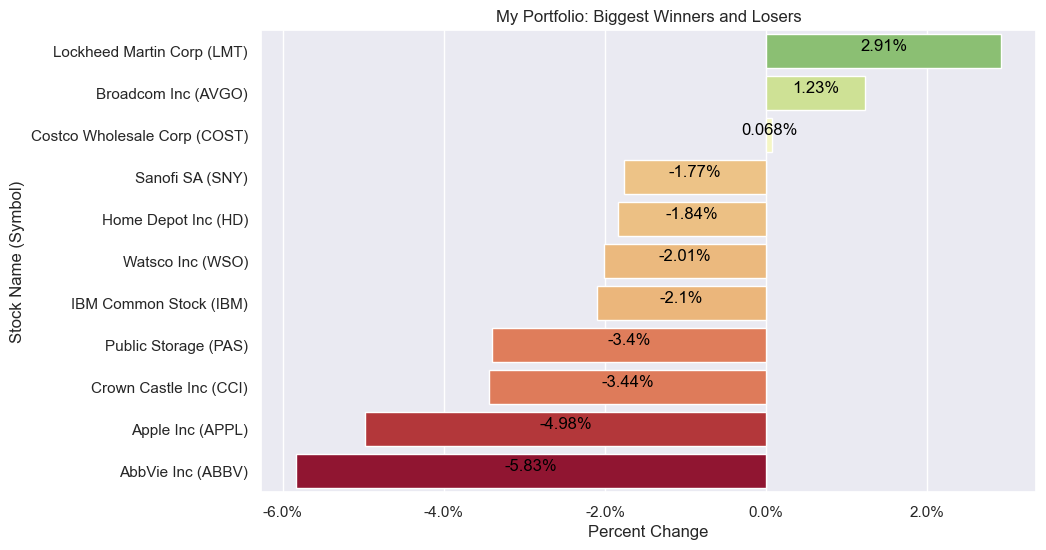

In [17]:
# Create a copy of my_updated_portfolio, sorted by Percent Change in q1_df.
q1_df = my_updated_portfolio.copy().sort_values(by='Percent Change', ascending=False)

# Re-index the rows based on the sorted Percent Change.
q1_df.reset_index(drop=True, inplace=True)

# Create a new column called Name (Symbol) which is the concatenation of Stock Name and (Symbol). 
q1_df['Stock Name (Symbol)'] = q1_df['Stock Name'] + ' (' + q1_df['Symbol'] + ')'

# Determine the maximum absolute value for Percent Change to determine gradient.
max_abs_value = max(abs(q1_df['Percent Change'].min()), abs(q1_df['Percent Change'].max()))

# Create a gradient palette from -max_abs_value to +max_abs_value, from red to green.
norm = plt.Normalize(max_abs_value * (-1), max_abs_value)
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])
palette = [sm.to_rgba(value) for value in q1_df['Percent Change']]

# Create Bar Plot using Seaborn.
sns.set(rc={'figure.figsize':(10,6)})
barplot = sns.barplot(y='Stock Name (Symbol)', 
                      x='Percent Change', 
                      data=q1_df, 
                      hue='Stock Name (Symbol)', 
                      palette=palette, 
                      legend=False
                     )

# Add Title, tick formatting and values within bars using matplotlib.
plt.title('My Portfolio: Biggest Winners and Losers')  # Set Title for plot.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))  # Append '%' to x number ticks.
for index, row in q1_df.iterrows():                    # Put values in bars.
    barplot.text(row['Percent Change'] / 2, index, f'{row["Percent Change"]}%', color='black', ha="center")

##### Question 1 Conclusions:
The percent change, ordering, etc. is dynamic based on when the code was last run.  
Based on the last run:  
* Lockheed Marting was the best gainer in 'My Portfolio', gaining 2.92%. It was followed by Broadcom and Costco with gains of 1.23% and 0.068% respectively.
* Abvie was the biggest loser in 'My Portfolio', losing 5.79%. It was followed by Apple and Crown Castle with losses of 4.98% and 3.44% respectively.
* Overall, 8 of my stocks lost value, 2 gained and one was unchanged (very sligh increase). 

### QUESTION 2:  
### What is the Total Value, Total Change and Percent Change in My Portfolio in this trading session?  
##### Approach:  
1. Make a blank dataframe specifically for answering this question, calling it 'q2_df' (Question 2 DataFrame), with columns 'Name', 'Value', 'Change' and 'Percent Change'.  
2. Add a single row to the new dataframe where 'Name' = 'My Portfolio', 'Value' = sum of 'Total Value' from my_updated_portfolio, 'Change' = sum of 'Total Change' from my_updated_portfolio, and 'Percent Change' = 'Change' / ('Value' - 'Change'), each formated accorind to USD or percentage.
3. Display the q2_df dataframe.

In [18]:
# Create a blank DataFrame
q2_df = pd.DataFrame(columns=['Name', 'Value', 'Change', 'Percent Change'])

# Add a single row with formatted values
q2_df = pd.concat([
    q2_df,
    pd.DataFrame([{
        'Name': 'My Portfolio',
        'Value': f"${my_updated_portfolio['Total Value'].sum():,.2f}",
        'Change': f"${my_updated_portfolio['Total Change'].sum():,.2f}",
        'Percent Change': f"{(my_updated_portfolio['Total Change'].sum() / (my_updated_portfolio['Total Value'].sum() - my_updated_portfolio['Total Change'].sum())):.2%}"
    }])
], ignore_index=True)

# Display q2_df dataframe.
q2_df

,Name,Value,Change,Percent Change
0,My Portfolio,"$277,372.20","$-1,079.70",-0.39%


##### Question 2 Conclusions:
The value, change and percent change for the 'My Portfolio' of stocks fell during this trading session.

While the values are dynamic and will change with each code execution, during this particular session My Portfolio lost $1077.70, 0.39% of the value at the trading session start. 

### QUESTION 3:  
### How did My Portfolio perform against Market Indexes this trading session?  
##### Approach:
1. Make a blank dataframe specifically for answering this question, calling it 'q3_df' (Question 3 DataFrame), with columns 'Name', 'Value', 'Change' and 'Percent Change'.  
2. Add a single row to the new dataframe where 'Name' = 'My Portfolio', 'Value' = sum of 'Total Value' from my_updated_portfolio, 'Change' = sum of 'Total Change' from my_updated_portfolio, and 'Percent Change' = 'Change' / ('Value' - 'Change').
3. Concatinate indextes_df to q3_df.
4. Sort q3_df by 'Percent Change' and re-index the dataframe.
5. Set palette to 'My Portfolio' = red and everything else to blue.
6. Display a horizontal bar plot of 'Percent Change' vs. portfolio/indexe names.

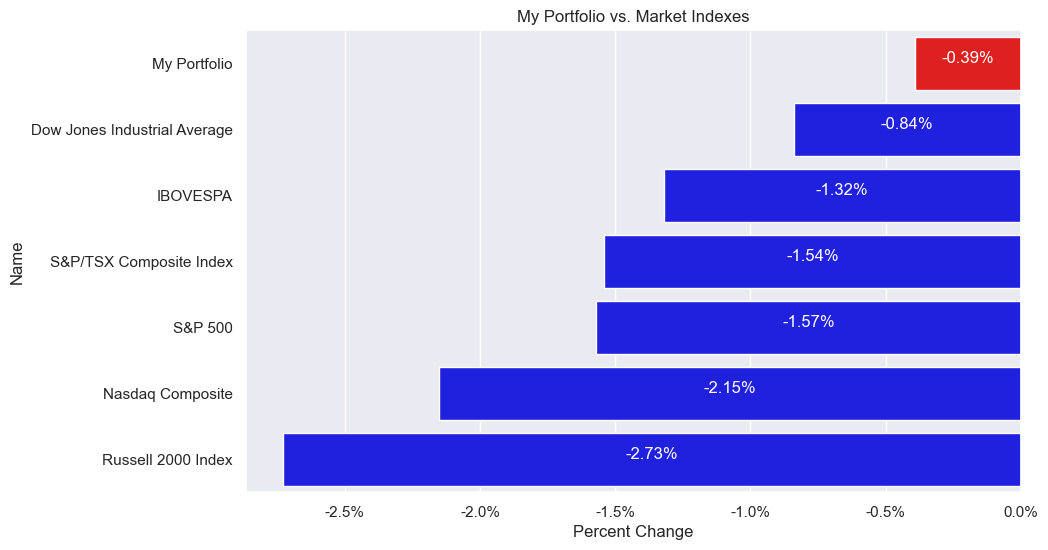

In [19]:
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create a blank DataFrame
q3_df = pd.DataFrame(columns=['Name', 'Value', 'Change', 'Percent Change'])

# Add a single row with formatted values
q3_df = pd.concat([
    q3_df,
    pd.DataFrame([{
        'Name': 'My Portfolio',
        'Value': my_updated_portfolio['Total Value'].sum(),
        'Change': my_updated_portfolio['Total Change'].sum(),
        'Percent Change': round((my_updated_portfolio['Total Change'].sum() / (my_updated_portfolio['Total Value'].sum() - my_updated_portfolio['Total Change'].sum()) * 100), 2)
    }])
], ignore_index=True)

# Append the indexes DataFrame to q3_df
q3_df = pd.concat([
    q3_df, 
    indexes_df.rename(columns={
        'name': 'Name', 
        'value': 'Value', 
        'change': 'Change', 
        'pct_chg': 'Percent Change'
    })
], ignore_index=True)

# Sort q3_df by 'Percent Change' from highest to lowest and re-index.
q3_df = q3_df.sort_values(by='Percent Change', ascending=False).reset_index(drop=True)

# Create a color palette where "My Portfolio" is red and the rest are blue
palette = ['red' if name == "My Portfolio" else "blue" for name in q3_df['Name']]

# Create Bar Plot using Seaborn.
sns.set(rc={'figure.figsize':(10,6)})
barplot = sns.barplot(y='Name', 
                      x='Percent Change', 
                      data=q3_df, 
                      hue='Name', 
                      palette=palette#, 
                      #legend=False
                     )

# Add Title, tick formatting and values within bars using matplotlib.
plt.title('My Portfolio vs. Market Indexes')  # Set Title for plot.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))  # Append '%' to x number ticks.
for index, row in q3_df.iterrows():                    # Put values in bars.
    barplot.text(row['Percent Change'] / 2, index, f'{row["Percent Change"]}%', color='white', ha="center")


##### Question 3 Conclusions:
All of the US Market Indexes and My Portfolio lost value today. However My Portfolio lost less than all of the US Market Indexes, losing only 0.39% while the US Market Indexes lost between 0.84% and 2.73%. So My Portfolio out-performed the 6 most popular US Market Indexes. 


### QUESTION 4: 
### How did My Portfolio atocks perform against Most Active, Top Gainers and Top Losers?  
##### Approach:
Prepare the data by:  
1. Make a blank dataframe specifically for answering this question, calling it 'q4_df' (Question 4 DataFrame), with columns 'Portfolio', 'Stock', 'Value', 'Change' and 'Percent Change'.  
2. Concatinate the 'my_updated_portfolio' to 'q4_df', only taking corresponding values.  
3. Concatinate 'actives_df' to 'q4_df'.  
4. Concatinate 'gainers_df' to 'q4_df'.  
5. Concatinate 'losers_df' to 'q4_df'.  

Visualize the 'Percent Change' data against 'Portfolio' a number of different ways and draw some conclusions not only about the data, but about the visualization as well:
1. Histogram
2. Box Plot
3. Violin Plot
4. Density Plot
5. Strip Plot
6. Swarm Plot

In [20]:
# Suppress FutureWarning.
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create a blank DataFrame.
q4_df = pd.DataFrame(columns=['Portfolio', 'Stock', 'Value', 'Change', 'Percent Change'])

# Concatenate my_updated_portfolio to q4_df with the specified column mappings.
q4_df = pd.concat([
    q4_df,
    my_updated_portfolio[['Stock Name', 'Value', 'Change', 'Percent Change']].rename(columns={
        'Stock Name': 'Stock',
        'Value': 'Value',
        'Change': 'Change',
        'Percent Change': 'Percent Change'
    }).assign(Portfolio='My Portfolio')
], ignore_index=True)

# Concatenate actives_df to q4_df with the specified column mappings.
q4_df = pd.concat([
    q4_df,
    actives_df.rename(columns={
        'name': 'Stock',
        'value': 'Value',
        'change': 'Change',
        'pct_chg': 'Percent Change'
    }).assign(Portfolio='Most Active')
], ignore_index=True)

# Concatenate gainers_df to q4_df with the specified column mappings
q4_df = pd.concat([
    q4_df,
    gainers_df.rename(columns={
        'name': 'Stock',
        'value': 'Value',
        'change': 'Change',
        'pct_chg': 'Percent Change'
    }).assign(Portfolio='Top Gainers')
], ignore_index=True)

# Concatenate losers_df to q4_df with the specified column mappings
q4_df = pd.concat([
    q4_df,
    losers_df.rename(columns={
        'name': 'Stock',
        'value': 'Value',
        'change': 'Change',
        'pct_chg': 'Percent Change'
    }).assign(Portfolio='Top Losers')
], ignore_index=True)

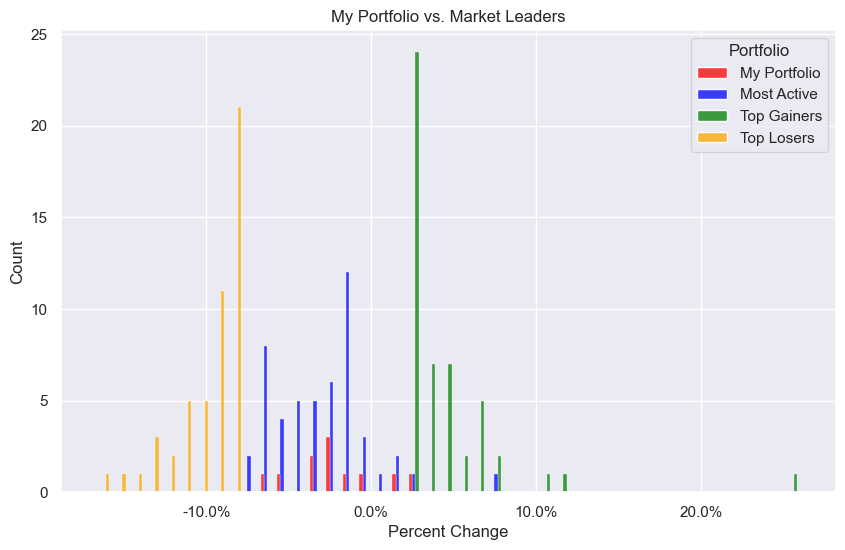

In [21]:
# Create a sns histplot for Percent Change by Portfolio for q4_df
sns.set(rc={'figure.figsize':(10,6)})
histplot = sns.histplot(
    x='Percent Change', 
    data=q4_df,
    binwidth=1,
    hue='Portfolio',
    palette={'My Portfolio':'red', 'Most Active':'blue', 'Top Gainers':'green', 'Top Losers':'orange'},
    multiple='dodge',
    shrink=0.8
)

# Add Title, tick formatting.
plt.title('My Portfolio vs. Market Leaders')  # Set Title for plot.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))  # Append '%' to x number ticks.

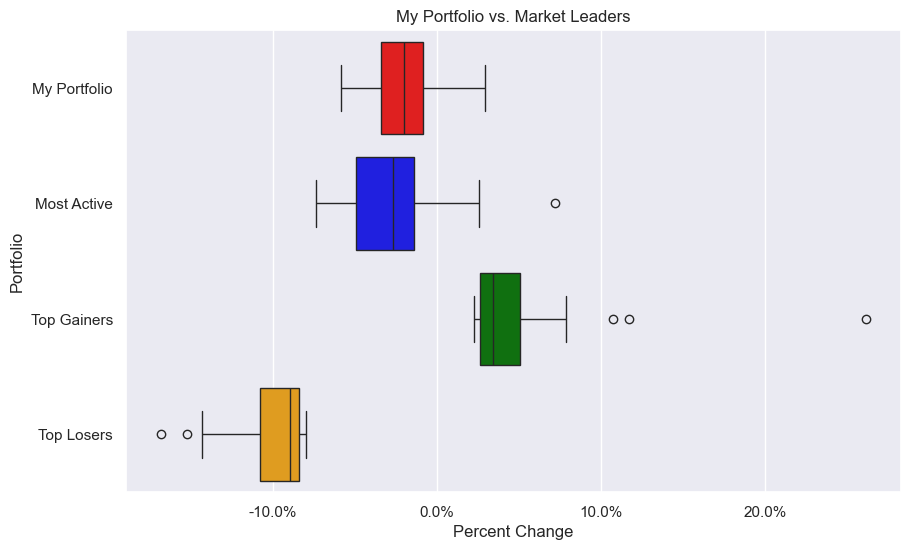

In [22]:
# Create a sns boxplot for Percent Change by Portfolio for q4_df
sns.set(rc={'figure.figsize':(10,6)})
boxplot = sns.boxplot(
    x='Percent Change', 
    y='Portfolio', 
    data=q4_df,
    hue='Portfolio',
    palette=['red', 'blue', 'green', 'orange']
)

# Add Title, tick formatting.
plt.title('My Portfolio vs. Market Leaders')  # Set Title for plot.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))  # Append '%' to x number ticks.

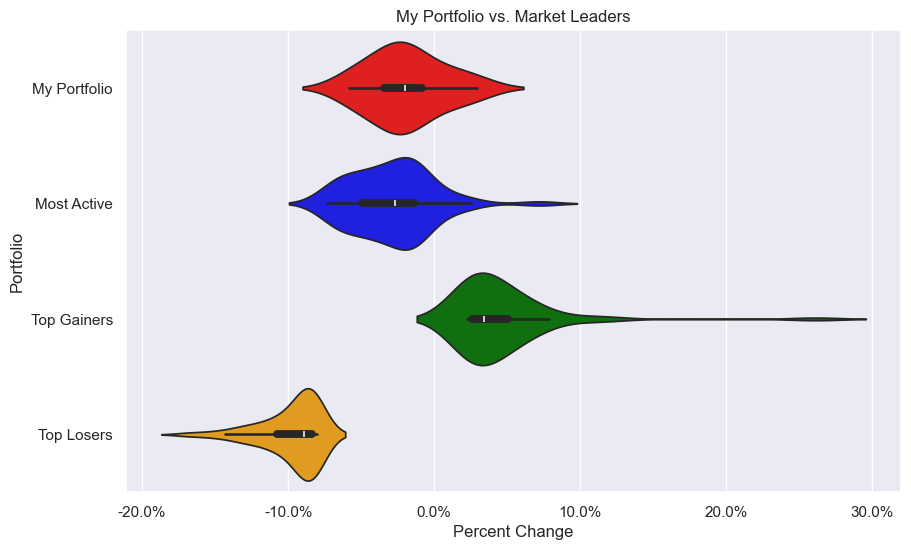

In [23]:
# Create a sns violin plot for Percent Change by Portfolio for q4_df
sns.set(rc={'figure.figsize':(10,6)})
violinplot = sns.violinplot(
    x='Percent Change', 
    y='Portfolio', 
    data=q4_df,
    hue='Portfolio',
    palette=['red', 'blue', 'green', 'orange']
)

# Add Title, tick formatting.
plt.title('My Portfolio vs. Market Leaders')  # Set Title for plot.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))  # Append '%' to x number ticks.

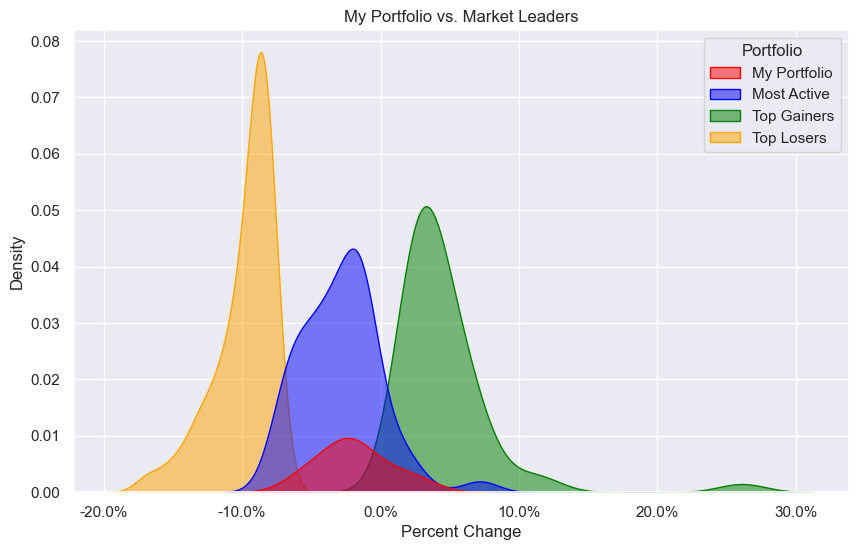

In [24]:
# Create a sns KDE plot for Percent Change by Portfolio for q4_df
sns.set(rc={'figure.figsize':(10,6)})
kdeplot = sns.kdeplot(
    x='Percent Change', 
    data=q4_df,
    hue='Portfolio',
    palette=['red', 'blue', 'green', 'orange'],
    fill=True,
    alpha=0.5
)

# Add Title, tick formatting.
plt.title('My Portfolio vs. Market Leaders')  # Set Title for plot.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))  # Append '%' to x number ticks.

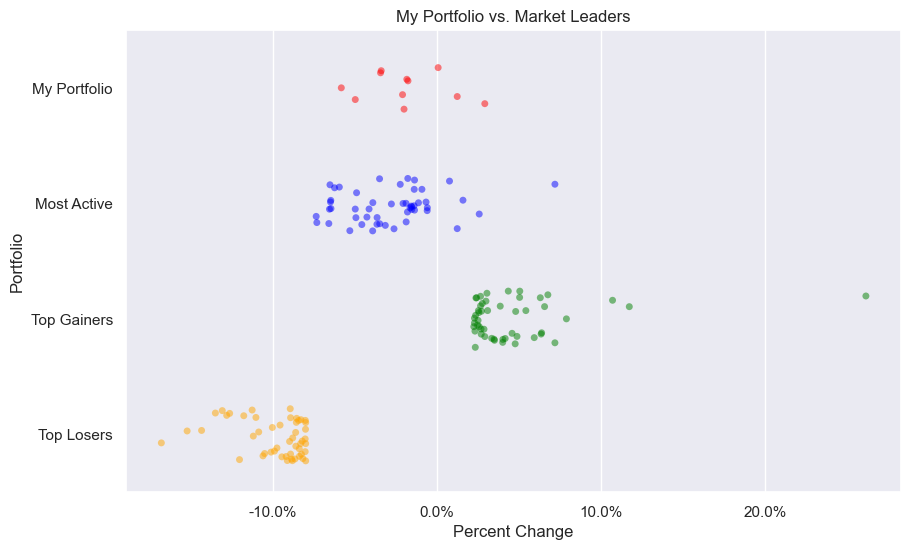

In [25]:
# Create a sns Strip Plot plot for Percent Change by Portfolio for q4_df
sns.set(rc={'figure.figsize':(10,6)})
stripplot = sns.stripplot(
    x='Percent Change', 
    y='Portfolio',
    data=q4_df,
    hue='Portfolio',
    palette=['red', 'blue', 'green', 'orange'], 
    jitter=0.25, 
    alpha=0.5
)

# Add Title, tick formatting.
plt.title('My Portfolio vs. Market Leaders')  # Set Title for plot.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))  # Append '%' to x number ticks.

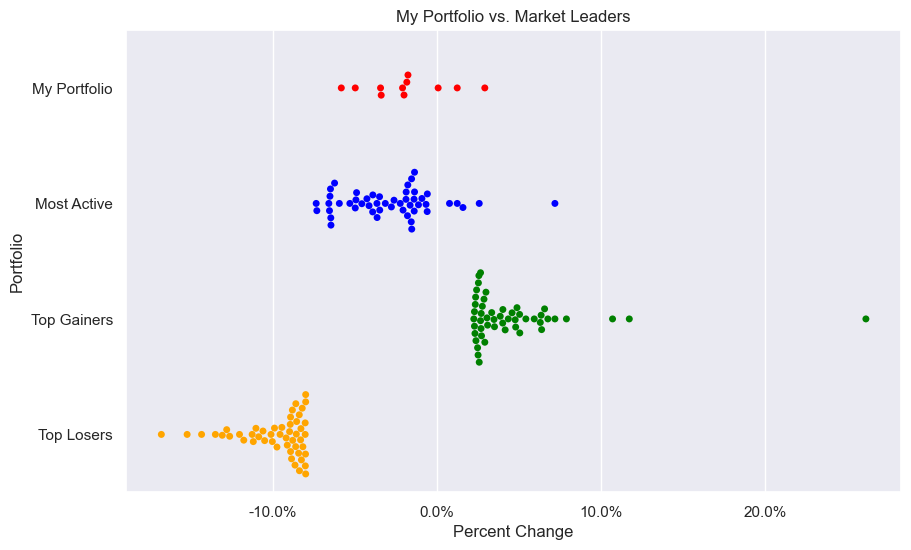

In [26]:
# Create a sns Swarm Plot for Percent Change by Portfolio for q4_df
sns.set(rc={'figure.figsize':(10,6)})
swarmplot = sns.swarmplot(
    x='Percent Change', 
    y='Portfolio',
    data=q4_df,
    hue='Portfolio',
    palette=['red', 'blue', 'green', 'orange']
)

# Add Title, tick formatting.
plt.title('My Portfolio vs. Market Leaders')  # Set Title for plot.
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x}%'))  # Append '%' to x number ticks.

##### Question 4 Conclusions:  
About the Data:  
* My Portfolio performed better than the 'Top Losers' and worse than the 'Top Gainers', with little to no overlap.  
* My Portfolio performed slightly better than the 'Most Active' stocks, with considerable overlap.
* The number of stocks in My Portfolio is less than all three Leader Portfolios.  

Histogram:  
* This plot was a poor visualization for this data. I don't think there was enough contiguous data in each to make a meaningful plot here. I tried stacked, proportional stacked and clustered. Tried a number of different binwidths as well. None seemed to provide any meaningful insights. Typically, I would not use this to dispay this data in a report or to make a point. It was left in for this assingment to demonstrate I could generate it.    

Box Plot and Violin Plot:
* The Box Plot showed very clearly how the mean, IQR, total range and outliers compared between the portfolios. It showed where the bulk of the data resided for each portfolio, and how the portfolios compared to and overlapped each other. You could also get an idea of relative variance portfolio to portfolio. This was a very effective plot for comparing the percent change between portfolios.  
* The Violin Plot had all of the same benefits of the Box Plot, but additional insight into the distribution of data within each portfolio, which was not visible in the Box Plot. We also get a hint of the skew of each portfolio. Another very good plot for comparing this data.

KDE Plot:
* The KDE Plot clearly shows the distribution of each portfolio relative to one another. We can also see the magnitude of the counts. You can surmise the mean, but it is difficult to see with any accuracy. The same could be said for IQR. This plot also shows the number of stocks in My Portfolio is smaller than the other three Leader Portfolios. It shows My Portfolio to have a relatively normal distribution, while Most Active and Top Gainers are clearly skewed right, and Top Losers are skewed left. This is a good supporting plot for this data.  

Strip and Swarm Plot:
* Shows individual datapoints, clustering and distribution well. We are looking at the raw data points. These plots clearly show the highest density for Top Losers near the top of the range, and the same for Top Gainers at the bottom of the range. We can surmise that the Top Gainers will always be greater than the Top Losers, and with the highest desities of each towards the center, that these are two slices of a much larger normal distribution.  

### QUESTION 5: 
### Do any stocks in My Portfolio appear in Most Active, Top Gainers or Top Losers?   
##### Approach:  
1. Make a copy of 'my_updated_portfolio' in 'q5_df' dataframe (Question 5 DataFrame). Only bring over the 'Stock Name' column.
2. Check if 'Stock Name' for each row in 'q5_df' is in the 'name' column of each of the leader dataframes (actives_df, gainers_df & losers_df). Populate newly created 'Exists in' column corresponding to each leader dataframe.
3. In each of the 3 'Exists in' colums, convert True to 'Yes' and False to '' for readability.
4. Display the q5_df.

In [27]:
q5_df = my_updated_portfolio[['Stock Name']].copy()

# Check if each 'Stock Name' exists in 'name' column of each leader dataframe (actives_df, gainters_df, losers_df).
q5_df['Exists in Most Active'] = q5_df['Stock Name'].isin(actives_df['name'])
q5_df['Exists in Top Gainers'] = q5_df['Stock Name'].isin(gainers_df['name'])
q5_df['Exists in Top Losers'] = q5_df['Stock Name'].isin(losers_df['name'])

# Replace True with 'Yes' and False with '' for readability.
q5_df['Exists in Most Active'] = q5_df['Exists in Most Active'].replace({True: 'Yes', False: ''})
q5_df['Exists in Top Gainers'] = q5_df['Exists in Top Gainers'].replace({True: 'Yes', False: ''})
q5_df['Exists in Top Losers'] = q5_df['Exists in Top Losers'].replace({True: 'Yes', False: ''})

# Display q5_df.
q5_df


,Stock Name,Exists in Most Active,Exists in Top Gainers,Exists in Top Losers
0,AbbVie Inc,,,
1,Apple Inc,Yes,,
2,Broadcom Inc,Yes,,
3,Costco Wholesale Corp,,,
4,Crown Castle Inc,,,
5,Home Depot Inc,,,
6,IBM Common Stock,,,
7,Lockheed Martin Corp,,Yes,
8,Public Storage,,,
9,Sanofi SA,,,


##### Question 5 Conclusions:
Apple and Broadcom were both found in the Most Active Stocks portfolio.  
Lockheed Martin was found in the Top Gainers portfolio.